# This notebook contains functions to plot figures involving multiple station pairs.

In [1]:
import os,random,time,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from seisgo import noise,utils,dispersion
import pygmt as gmt
from scipy.stats import linregress

## Global parameters

In [2]:
from scipy.optimize import curve_fit
def expfunc(x, a,b):
    return  a*np.exp(-b * x)

In [3]:
bootstrap_size,sample_ratio=1000,0.8 #1000 tries. 80% resampling rate.
infile="xcorr_stacks_allpair_bootstrap_XZ_"+str(bootstrap_size)+"r"+str(sample_ratio)+".pk"
dataroot='data_stacking'
raw_xz=os.path.join(dataroot,"MERGED_XZ_raw")
tnorm_xz=os.path.join(dataroot,"MERGED_XZ_tnorm")

comp="ZZ"
## Cascadia amphibious array and XZ moveout plots with all stacking methods
figformat="png"
figdpi=300
XZ_source="XZ.A02"
network_xz="XZ"
dlabels=["Raw","One-bit"]
cmap="seismic"
methods=["linear","robust","selective","cluster","pws","tfpws-dost","nroot","acf"]
method_labels=["Linear","Robust","Selective","Cluster","PWS","tf-PWS","$N^{th}$-root","ACF"]
colors=["k","b","c","y","g","orange","r","m"]
figlabels=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)"]

## Get the number of NCFs for each pair

In [4]:
XZ_source="XZ.A02"
network="XZ"
flist_xz=[utils.get_filelist(raw_xz+"/"+XZ_source,"h5"),
          utils.get_filelist(tnorm_xz+"/"+XZ_source,"h5")]

ntrace_all=dict()

for i,flist in enumerate(flist_xz):
    print(dlabels[i])
    ntrace_all[dlabels[i]]=[]
    for j,f0 in enumerate(flist):
        f=f0.replace("\n","")
        cdict=noise.extract_corrdata(f,comp=comp)
        p=list(cdict.keys())[0]
        cdata=cdict[p][comp]
        ntrace_all[dlabels[i]].append(cdata.data.shape[0])

Raw
One-bit


## Load data.

In [5]:
with open(infile,'rb') as xf:
    stack_all_xz_bs=pickle.load(xf)
# get general parameters
dist_all_xz_bs=stack_all_xz_bs["dist"]
src_all_bs=stack_all_xz_bs["receivers"]
maxlag_xz=stack_all_xz_bs["maxlag"]
dt_xz=stack_all_xz_bs["dt"]
npts_xz=stack_all_xz_bs["npts"]

## Plot moveout showing the bootstrap mean of NCFs

In [6]:
savefig=True
freqmin_xz,freqmax_xz=[0.1,0.4]
vmin_xz=2
vmax_xz=3.7
dist_xz=[vmax_xz/freqmin_xz,240]
std_width=1 #width of NCF (# of std) to show the distribution.
scale=8
figsize=(12,5.5)
lag=160
ntrace_minimum=5
snr_window_extend_xz=20
if lag>maxlag_xz:raise ValueError('lag excceds maxlag!')
tvec_xz=np.arange(-maxlag_xz,maxlag_xz+0.5*dt_xz,dt_xz)
for i,dlabel in enumerate(dlabels):

    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Bootstrap mean NCFs for virtual source: "+XZ_source+": "+dlabels[i]\
                 +": "+str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",fontsize=14)
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        for k in range(stack_all_xz_bs[dlabels[i]]["mean"].shape[1]):
            if dist_all_xz_bs[dlabels[i]][k] >= dist_xz[0] and dist_all_xz_bs[dlabels[i]][k] <= dist_xz[1] \
                    and ntrace_all[dlabels[i]][k] >= ntrace_minimum:
                #plot range: 1 std
#                 dp_std = bandpass(stack_all_xz[dlabels[i]]["std"][j,k,:],freqmin_xz,freqmax_xz,1/dt_xz,
#                               corners=4, zerophase=True)
                dp = bandpass(stack_all_xz_bs[dlabels[i]]["mean"][j,k,:],freqmin_xz,freqmax_xz,1/dt_xz,
                              corners=4, zerophase=True)
                if np.max(np.abs(dp))>0:
                    plt.plot(tvec_xz,dist_all_xz_bs[dlabels[i]][k]+scale*dp/np.max(np.abs(dp)),
                             color=[.2,.2,.2],linewidth=0.75,alpha=1)
        # plot signal window
        plt.plot([snr_window_extend_xz + dist_xz[0]/vmin_xz,snr_window_extend_xz+ dist_xz[1]/vmin_xz],
                 dist_xz,'r',lw=1)
        plt.plot([dist_xz[0]/vmax_xz,dist_xz[1]/vmax_xz],dist_xz,'r',lw=1)

        plt.plot([-snr_window_extend_xz - dist_xz[0]/vmin_xz,-snr_window_extend_xz- dist_xz[1]/vmin_xz],
                 dist_xz,'b--',lw=1)
        plt.plot([-dist_xz[0]/vmax_xz,-dist_xz[1]/vmax_xz],dist_xz,'b--',lw=1)

        plt.xlim([-lag,lag])
        plt.ylim([dist_xz[0]-0.5*scale,dist_xz[1]+0.5*scale])
        if j>=4:
            plt.xlabel('lag time (s)',fontsize=12)
        if j==0 or j==4:
            plt.ylabel('distance (km)',fontsize=12)
#         plt.text(-0.9*lag,dist_xz[0]+20,m,backgroundcolor='w',fontsize=13)
        plt.title('%s %s' % (figlabels[j],m),
                        fontsize=14,loc="left",pad=9)
        plt.plot((0,0),dist_xz,'k-')
    plt.tight_layout()
    if savefig:
        plt.savefig("Figure-X_xcorr_stacks_allpair_moveout_XZ_%s_bootstrap_mean.%s"%(dlabels[i],figformat),
                    dpi=figdpi)
        plt.close()
    else:
        plt.show()

## Bootstrap std
This is a testing cell, not used in paper.

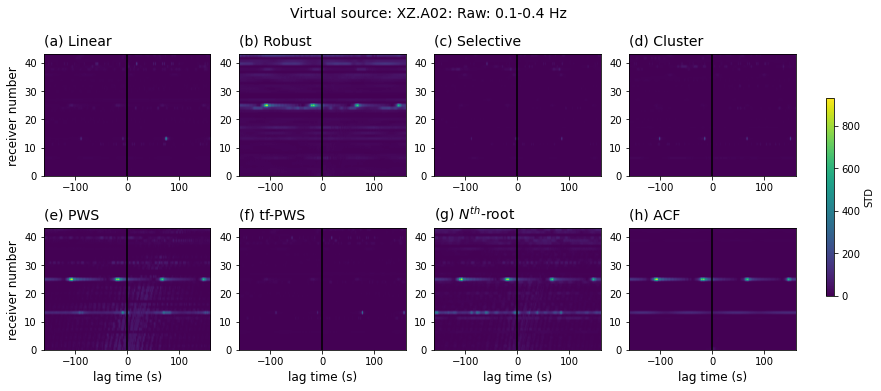

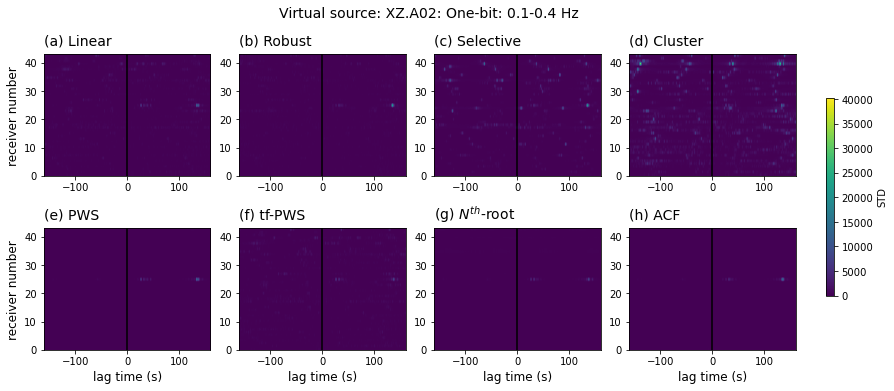

In [7]:
savefig=False

figsize=(12,5.5)
lag=160

snr_window_extend_xz=20
if lag>maxlag_xz:raise ValueError('lag excceds maxlag!')
tvec_xz=np.arange(-maxlag_xz,maxlag_xz+0.5*dt_xz,dt_xz)

for i,dlabel in enumerate(dlabels):
    sort_idx_dist=np.flip(np.argsort(dist_all_xz_bs[dlabels[i]]))
    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Virtual source: "+XZ_source+": "+dlabels[i]\
                 +": "+str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",fontsize=14)
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        dtest=stack_all_xz_bs[dlabels[i]]["std"][j][sort_idx_dist[::-1]]
        dtest_mean=np.abs(stack_all_xz_bs[dlabels[i]]["mean"][j][sort_idx_dist[::-1]])
        if i==0: dtest_mean[dtest_mean<1e-13]=1e-13
        else: dtest_mean[dtest_mean<10]=10
        im=plt.imshow(100*dtest/dtest_mean,
          aspect='auto',extent=[-maxlag_xz,maxlag_xz,stack_all_xz_bs[dlabels[i]]["std"][j].shape[0]-1,0])
        plt.ylim([0,stack_all_xz_bs[dlabels[i]]["std"][j].shape[0]-1])
        plt.xlim([-lag,lag])
#         plt.clim([0,100])
#         if i==0: 
#             plt.clim([0,5e-12])
#         else:
#             plt.clim([0,3000])
        if j>=4:
            plt.xlabel('lag time (s)',fontsize=12)
        if j==0 or j==4:
            plt.ylabel('receiver number',fontsize=12)
#         plt.text(-0.9*lag,dist_xz[0]+20,m,backgroundcolor='w',fontsize=13)
        plt.title('%s %s' % (figlabels[j],m),
                        fontsize=14,loc="left",pad=9)
        plt.plot((0,0),[0,stack_all_xz_bs[dlabels[i]]["mean"][j].shape[0]],'k-')
#         print(i,j)
#         try:
#             plt.colorbar()
#         except Exception as e:
#             print(e)
    plt.tight_layout()
    fig.subplots_adjust(right=.925)
    cbar_ax = fig.add_axes([0.96, 0.25, 0.01, 0.5])
    ax=fig.colorbar(im, cax=cbar_ax)
    ax.set_label('STD')
    
    if savefig:
        plt.savefig("Figure-X_xcorr_stacks_allpair_XZ_%s_bootstrap_std_image.%s"%(dlabels[i],figformat),
                    dpi=figdpi)
        plt.close()
    else:
        plt.show()

## Analyze peak amplitudes of bootstrap mean NCFs

In [8]:
savefig=True
freqmin,freqmax=[0.1,0.4]
vmin_xz=2
vmax_xz=3.7
stat_name="mean"
# ntrace_minimum=2
ref_exp_pow1=[0.0051,0.0077] #Pireto et al., 2009, for period at 5 s
ref_exp_pow2=[0.001,0.003] #Mitchell, 1995, at around 6-10 s, for tectonically active regions.
ref_exp_pow3=0.014 #Viens et al., 2017, at 3-10 s, no std given

#
###amplitudes
lag=200
if not lag:lag=maxlag_xz
if lag>maxlag_xz:raise ValueError('lag excceds maxlag!')
tvec_xz=np.arange(-maxlag_xz,maxlag_xz+0.5*dt_xz,dt_xz)

peakamp_xz=dict()
peaktt_xz=dict()
halfn_xz=int(len(tvec_xz)/2)
dist_peakamp=dict()
for i in range(len(dlabels)):
    ntrace=stack_all_xz_bs[dlabels[i]][stat_name].shape[1]
    peakamp_xz[dlabels[i]]=np.ndarray((len(methods),ntrace,2)) #negative and positive sides.
    peaktt_xz[dlabels[i]]=np.ndarray((len(methods),ntrace,2)) #negative and positive sides.
    dist_peakamp[dlabels[i]]=[]
    for j,m in enumerate(method_labels):
        for k in range(ntrace):
            dp = bandpass(stack_all_xz_bs[dlabels[i]][stat_name][j,k,:],freqmin,freqmax,1/dt_xz,corners=4, 
                          zerophase=True)
            if np.max(np.abs(dp))>0.0 and ntrace_all[dlabels[i]][k] >= ntrace_minimum:
                d0=dist_all_xz_bs[dlabels[i]][k]
                sig_idx_p=[int(d0/vmax_xz/dt_xz)+halfn_xz,
                           halfn_xz+int(d0/vmin_xz/dt_xz + snr_window_extend_xz/dt_xz)]
                sig_idx_n=[len(tvec_xz) - sig_idx_p[1],len(tvec_xz) - sig_idx_p[0]]
                dp=np.abs(dp)
                peakamp_xz[dlabels[i]][j,k,:]=[np.max(dp[sig_idx_n[0]-1:sig_idx_n[1]+1]),
                                               np.max(dp[sig_idx_p[0]-1:sig_idx_p[1]+1])]
                ttidx=[np.argmax(dp[sig_idx_n[0]-1:sig_idx_n[1]+1]),
                       np.argmax(dp[sig_idx_p[0]-1:sig_idx_p[1]+1])]
                peaktt_xz[dlabels[i]][j,k,:]=[tvec_xz[ttidx[0]],tvec_xz[ttidx[1]]]
            else:
                peakamp_xz[dlabels[i]][j,k,:]=[np.nan,np.nan]
                peaktt_xz[dlabels[i]][j,k,:]=[np.nan,np.nan]

# fit
dist_xz=[vmax_xz/freqmin_xz,240]
figsize=(13,6.7)
ampfit_bootstrap=np.ndarray((len(dlabels),len(methods),2,2))
dist_fit=np.arange(dist_xz[0],dist_xz[1],1)
nsigma=2
for i in range(len(dlabels)):
    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Peak absolute amplitudes: "+dlabels[i],fontsize=14)
    dist_idx=np.where((dist_all_xz_bs[dlabels[i]]>= dist_xz[0]) & (dist_all_xz_bs[dlabels[i]]<= dist_xz[1]))[0]
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        # 
        dist_subset=dist_all_xz_bs[dlabels[i]][dist_idx]

        for k in range(2):
            if k==0: continue #skip negative side
            #correct for SQRT(distance) to account for geometrical spreading.
            amp_subset=np.multiply(np.sqrt(dist_subset),peakamp_xz[dlabels[i]][j,dist_idx,k])#

            #fit with linear regression after converting to natural log scale.
            amptemp=np.log(amp_subset)
            mask = (~np.isnan(amptemp) & ~np.isinf(amptemp))
            res0=linregress(dist_subset[mask],amptemp[mask])

            #remove extreme outliers
            amptemp00 = amptemp - (res0.intercept + res0.slope*dist_subset)
            amp_lb=np.nanmean(amptemp00) - nsigma*np.nanstd(amptemp00)
            amp_ub=np.nanmean(amptemp00) + nsigma*np.nanstd(amptemp00)
            goodidx=np.where((amptemp00 >= amp_lb) & (amptemp00 <= amp_ub))[0]
            ampfinal=amptemp[goodidx]
            distfinal=dist_subset[goodidx]
            res=linregress(distfinal,ampfinal)
            yl=expfunc(dist_fit,np.exp(res.intercept),-1*(res.slope-1.*res.stderr))
            yu=expfunc(dist_fit,np.exp(res.intercept),-1*(res.slope+1.*res.stderr))
            ampfit_bootstrap[i,j,k,:]=[-res.slope,res.stderr]
            if j==0:
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[0]),
                                 color=[0.5,0.5,0.5],label="P2009",alpha=0.7)
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[0]),
                                 color='b',label="M1995",alpha=0.4)
#                 plt.plot(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow3),
#                                  '-',
#                                  color='g',lw=4,label="V2017",alpha=0.6)

                plt.fill_between(dist_fit,yl,yu,alpha=0.5,color='r',
                                 label='This fit')
            else:
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[1]),
                             expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[0]),
                             color=[0.5,0.5,0.5],alpha=0.7)
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[0]),
                                 color='b',alpha=0.4)
#                 plt.plot(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow3),
#                                  '-',color='g',lw=4,alpha=0.6)
                plt.fill_between(dist_fit,yl,yu,alpha=0.5,color='r')

            plt.scatter(distfinal,amp_subset[goodidx],s=15,color='k',alpha=0.7)
            if i==0 and j==4:
                plt.text(0.95*np.max(dist_xz),1.1*np.nanmax(amp_subset[goodidx]),
                     '$\u03B1=%.4f$\n$\u03C3=%.4f$'%(-res.slope,res.stderr),color='r',alpha=1,ha="right",
                    fontsize=12)
            else:
                plt.text(0.95*np.max(dist_xz),0.85*np.nanmax(amp_subset[goodidx]),
                     '$\u03B1=%.4f$\n$\u03C3=%.4f$'%(-res.slope,res.stderr),color='r',alpha=1,ha="right",
                    fontsize=12)

        if j>=4: plt.xlabel('distance (km)',fontsize=12)
        if j==0 or j==4: plt.ylabel('peak amplitude',fontsize=12)
        plt.xlim([dist_xz[0]-2,np.max(dist_subset)])

#         plt.yscale('log')
        if j==0: plt.legend(fontsize=10.5,loc="lower left",edgecolor='none',
                   numpoints=5,borderpad=0.2)
        plt.title('%s %s' % (figlabels[j],m),
                            fontsize=14,loc="left",pad=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    plt.tight_layout()
    if savefig:
        plt.savefig("Figure-X_xcorr_stacks_ampfit_XZ_%s_bootstrap_%s_%s-%sHz.%s"%(dlabels[i],stat_name,
                                                             str(freqmin).replace(".","_"),
                                                             str(freqmax).replace(".","_"),figformat),
                    dpi=figdpi)
        plt.close()
    else:
        plt.show()


## Extract peak amplitude of the all-time NCFs without bootstrapping

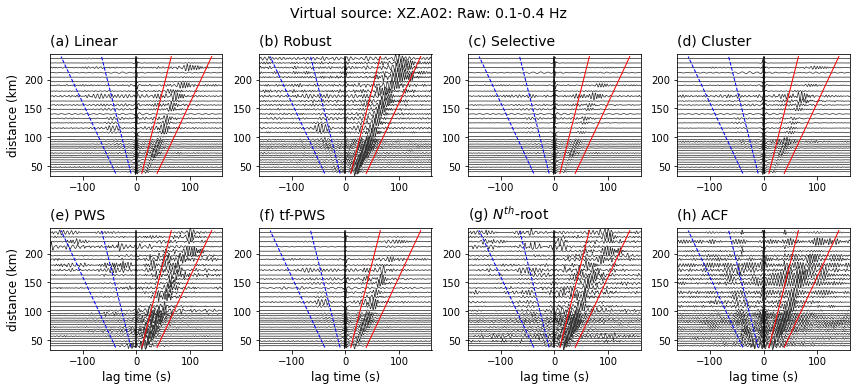

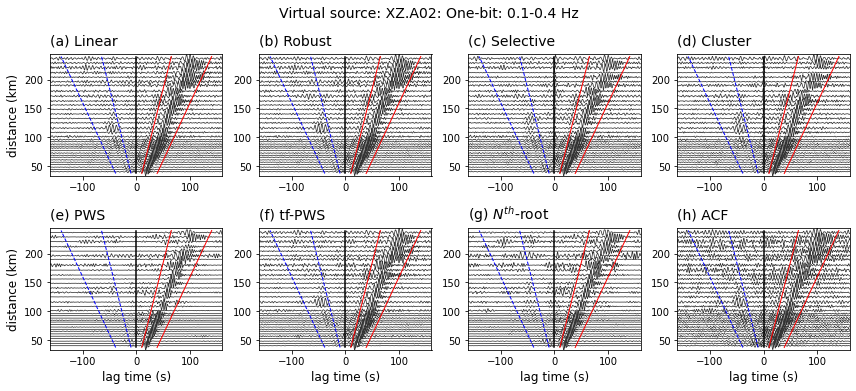

In [9]:
with open('xcorr_stacks_allpair_XZ.pk','rb') as xf:
    stack_all_xz=pickle.load(xf)
    dist_all_xz=pickle.load(xf)

#######
""" 
moveout plot
"""
figsize=(12,5.5)
lag=160
scale=8
savefig=False

for i in range(len(dlabels)):
    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Virtual source: "+XZ_source+": "+dlabels[i]\
                 +": "+str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",fontsize=14)
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        for k in range(stack_all_xz[dlabels[i]].shape[1]):
            if dist_all_xz[dlabels[i]][k] >= dist_xz[0] and dist_all_xz[dlabels[i]][k] <= dist_xz[1] \
                    and ntrace_all[dlabels[i]][k] >= ntrace_minimum:
                dp = bandpass(stack_all_xz[dlabels[i]][j,k,:],freqmin_xz,freqmax_xz,1/dt_xz,corners=4, zerophase=True)
                plt.plot(tvec_xz,dist_all_xz[dlabels[i]][k]+scale*dp/np.max(np.abs(dp)),
                             color=[.2,.2,.2],linewidth=0.75,alpha=1)
        # plot signal window
        plt.plot([snr_window_extend_xz + dist_xz[0]/vmin_xz,snr_window_extend_xz+ dist_xz[1]/vmin_xz],
                 dist_xz,'r',lw=1)
        plt.plot([dist_xz[0]/vmax_xz,dist_xz[1]/vmax_xz],dist_xz,'r',lw=1)
        
        plt.plot([-snr_window_extend_xz - dist_xz[0]/vmin_xz,-snr_window_extend_xz- dist_xz[1]/vmin_xz],
                 dist_xz,'b--',lw=1)
        plt.plot([-dist_xz[0]/vmax_xz,-dist_xz[1]/vmax_xz],dist_xz,'b--',lw=1)
        
        plt.xlim([-lag,lag])
        plt.ylim([dist_xz[0]-0.5*scale,dist_xz[1]+0.5*scale])
        if j>=4:
            plt.xlabel('lag time (s)',fontsize=12)
        if j==0 or j==4:
            plt.ylabel('distance (km)',fontsize=12)
#         plt.text(-0.9*lag,dist_xz[0]+20,m,backgroundcolor='w',fontsize=13)
        plt.title('%s %s' % (figlabels[j],m),
                        fontsize=14,loc="left",pad=9)
        plt.plot((0,0),dist_xz,'k-')
    plt.tight_layout()
    if savefig:
        plt.savefig("xcorr_stacks_allpair_moveout_XZ_%s.%s"%(dlabels[i],figformat),dpi=figdpi)
        plt.close()
    else:
        plt.show()
        
####
"""extract amplitudes"""
####
###amplitudes
lag=200
if not lag:lag=maxlag_xz
# freqmin,freqmax=[0.1,0.4]
# vmin_xz=2
# vmax_xz=3.7
peakamp_xz=dict()
peaktt_xz=dict()
halfn_xz=int(len(tvec_xz)/2)
for i in range(len(dlabels)):
    ntrace=stack_all_xz[dlabels[i]].shape[1]
    peakamp_xz[dlabels[i]]=np.ndarray((len(methods),ntrace,2)) #negative and positive sides.
    peaktt_xz[dlabels[i]]=np.ndarray((len(methods),ntrace,2)) #negative and positive sides.
    
    for j,m in enumerate(method_labels):
        for k in range(ntrace):
            dp = bandpass(stack_all_xz[dlabels[i]][j,k,:],freqmin,freqmax,1/dt_xz,corners=4, zerophase=True)
            if np.max(np.abs(dp)) >0.0 and ntrace_all[dlabels[i]][k] >= ntrace_minimum:
                d0=dist_all_xz[dlabels[i]][k]
                sig_idx_p=[int(d0/vmax_xz/dt_xz)+halfn_xz,
                           halfn_xz+int(d0/vmin_xz/dt_xz + snr_window_extend_xz/dt_xz)]
                sig_idx_n=[len(tvec_xz) - sig_idx_p[1],len(tvec_xz) - sig_idx_p[0]]
                dp=np.abs(dp)
                peakamp_xz[dlabels[i]][j,k,:]=[np.max(dp[sig_idx_n[0]-1:sig_idx_n[1]+1]),
                                               np.max(dp[sig_idx_p[0]-1:sig_idx_p[1]+1])]
                ttidx=[np.argmax(dp[sig_idx_n[0]-1:sig_idx_n[1]+1]),
                       np.argmax(dp[sig_idx_p[0]-1:sig_idx_p[1]+1])]
                peaktt_xz[dlabels[i]][j,k,:]=[tvec_xz[ttidx[0]],tvec_xz[ttidx[1]]]
            else:
                peakamp_xz[dlabels[i]][j,k,:]=[np.nan,np.nan]
                peaktt_xz[dlabels[i]][j,k,:]=[np.nan,np.nan]
####
"""
Fit with exponential functions.
"""
dist_xz=[vmax_xz/freqmin,240]
ampfit_all_xz=np.ndarray((len(dlabels),len(methods),2,2))
savefig=True
figsize=(13,6.7)
dist_fit=np.arange(dist_xz[0],dist_xz[1],1)
for i in range(len(dlabels)):
    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Peak absolute amplitudes: "+dlabels[i],fontsize=14)
    dist_idx=np.where((dist_all_xz[dlabels[i]]>= dist_xz[0]) & (dist_all_xz[dlabels[i]]<= dist_xz[1]))[0]
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        # 
        dist_subset=dist_all_xz[dlabels[i]][dist_idx]
        
        for k in range(2):
            if k==0: continue #skip negative side
            #correct for SQRT(distance) to account for geometrical spreading.
            amp_subset=np.multiply(np.sqrt(dist_subset),peakamp_xz[dlabels[i]][j,dist_idx,k])#

            #fit with linear regression after converting to natural log scale.
            amptemp=np.log(amp_subset)
            mask = ~np.isnan(amptemp)
            res0=linregress(dist_subset[mask],amptemp[mask])
            
            #remove extreme outliers
            amptemp00 = amptemp - (res0.intercept + res0.slope*dist_subset)
            amp_lb=np.nanmean(amptemp00) - 1.*np.nanstd(amptemp00)
            amp_ub=np.nanmean(amptemp00) + 1.*np.nanstd(amptemp00)
            goodidx=np.where((amptemp00 >= amp_lb) & (amptemp00 <= amp_ub))[0]
            ampfinal=amptemp[goodidx]
            distfinal=dist_subset[goodidx]
            
            res=linregress(distfinal,ampfinal)
            yl=expfunc(dist_fit,np.exp(res.intercept),-1*(res.slope-1.*res.stderr))
            yu=expfunc(dist_fit,np.exp(res.intercept),-1*(res.slope+1.*res.stderr))
            ampfit_all_xz[i,j,k,:]=[-res.slope,res.stderr]
            if j==0:
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[0]),
                                 color=[0.5,0.5,0.5],label="P2009",alpha=0.7)
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[0]),
                                 color='b',label="M1995",alpha=0.4)
#                 plt.plot(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow3),
#                                  '-',
#                                  color='g',lw=4,label="V2017",alpha=0.6)
                
                plt.fill_between(dist_fit,yl,yu,alpha=0.5,color='r',
                                 label='This fit')
            else:
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[1]),
                             expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow1[0]),
                             color=[0.5,0.5,0.5],alpha=0.7)
                plt.fill_between(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[1]),
                                 expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow2[0]),
                                 color='b',alpha=0.4)
#                 plt.plot(dist_fit,expfunc(dist_fit,np.exp(res.intercept),ref_exp_pow3),
#                                  '-',color='g',lw=4,alpha=0.6)
                plt.fill_between(dist_fit,yl,yu,alpha=0.5,color='r')
            
            plt.scatter(distfinal,amp_subset[goodidx],s=15,color='k',alpha=0.7)
            if i==0 and j==4:
                plt.text(0.95*np.max(dist_xz),1.1*np.nanmax(amp_subset[goodidx]),
                     '$\u03B1=%.4f$\n$\u03C3=%.4f$'%(-res.slope,res.stderr),color='r',alpha=1,ha="right",
                    fontsize=12)
            else:
                plt.text(0.95*np.max(dist_xz),0.85*np.nanmax(amp_subset[goodidx]),
                     '$\u03B1=%.4f$\n$\u03C3=%.4f$'%(-res.slope,res.stderr),color='r',alpha=1,ha="right",
                    fontsize=12)

        if j>=4: plt.xlabel('distance (km)',fontsize=12)
        if j==0 or j==4: plt.ylabel('peak amplitude',fontsize=12)
        plt.xlim([dist_xz[0]-2,np.max(dist_subset)])
        
#         plt.yscale('log')
        if j==0: plt.legend(fontsize=10.5,loc="lower left",edgecolor='none',
                   numpoints=5,borderpad=0.2)
        plt.title('%s %s' % (figlabels[j],m),
                            fontsize=14,loc="left",pad=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    plt.tight_layout()
    if savefig:
        plt.savefig("Figure-X_xcorr_stacks_ampfit_XZ_%s_%s-%sHz.%s"%(dlabels[i],
                                                             str(freqmin).replace(".","_"),
                                                             str(freqmax).replace(".","_"),figformat),dpi=figdpi)
        plt.close()
    else:
        plt.show()
        

## Compute the deviation index
$DI=mean(|d_{all} - d_{bootstrap}|/\sigma)$, where $d_{all}$ and $d_{bootstrap}$ are the all-time and bootstrap mean NCF stacks, respectively, and $\sigma$ is the standard deviations from the bootstrapping.


In [10]:
savefig=True

figsize=(11,7.5)
fig=plt.figure(figsize=figsize,facecolor='w')
nsigma=1
# fig.suptitle("Mean relative STD for each pair from: "+XZ_source,fontsize=14)
for i,dlabel in enumerate(dlabels):
    plt.subplot(2,1,i+1)
    plt.hlines(1,-0.3,len(src_all_bs[i])-.7,colors='k',lw=5,alpha=0.5,label="baseline")
    for j,m in enumerate(method_labels):
        rstdpair=[]
        for k in range(stack_all_xz_bs[dlabels[i]]["mean"].shape[1]):
            d0=stack_all_xz[dlabels[i]][j][k]
            d_bs=stack_all_xz_bs[dlabels[i]]["mean"][j][k]
            std_bs=stack_all_xz_bs[dlabels[i]]["std"][j][k]
            
            if np.max(std_bs)>0 and ntrace_all[dlabels[i]][k] >= ntrace_minimum:
                conf_level=np.nanmean(np.abs(d0-d_bs)/(nsigma*std_bs))
                
                # remove outlier, which was caused by only one trace in the stack.
                if conf_level > 1e-5:
                    rstdpair.append(conf_level)
                else:
                    rstdpair.append(np.nan)
            else:
                rstdpair.append(np.nan)
        #    
        plt.plot(np.arange(0,len(src_all_bs[i])),rstdpair,'o-',color=colors[j],
                 markersize=3,lw=1,label=m)

    plt.title('%s virtual source %s: %s' % (figlabels[i],XZ_source,dlabel),
                        fontsize=14,loc="left",pad=9)
    if i==0:plt.legend(ncol=4,fontsize=11)
    plt.yscale('log')
    yticks=[20,40,80,200,400,800]
    ytickslabel=[]
    for y in range(len(yticks)):
        ytickslabel.append(str(yticks[y]))
#     plt.yticks(yticks,labels=ytickslabel,fontsize=12)
    plt.xticks(np.arange(0,len(src_all_bs[i])),labels=src_all_bs[i],rotation=60,fontsize=10)
    plt.xlim([-0.3,len(src_all_bs[i])-.7])
    plt.ylim([5e-3,3])
    plt.ylabel('DI',fontsize=12)
    plt.grid('both',ls='--',alpha=0.5)
    plt.legend(bbox_to_anchor=(1.01, 1.0),ncol=1,fontsize=12)
#         plt.plot((0,0),[0,stack_all_xz[dlabels[i]]["mean"][j].shape[0]],'k-')
plt.tight_layout()

if savefig:
    plt.savefig("Figure-S7_xcorr_stacks_allpair_XZ_%s_bootstrap_pairstd.%s"%(dlabels[i],figformat),
                dpi=figdpi)
    plt.close()
else:
    plt.show()

## Assemble and compare all exponential fits

In [11]:
barx=np.arange(0,len(method_labels))+1
savefig=True
xlim=[barx[0]-0.8,barx[-1]+0.8]
plt.figure(figsize=(12,4),facecolor='w')
for i in range(len(dlabels)):
    plt.subplot(1,2,i+1)
    plt.fill_between(xlim,np.ones(len(xlim))*ref_exp_pow1[0],np.ones(len(xlim))*ref_exp_pow1[1],
                     edgecolor=None,lw=None,facecolor=[0.6,0.6,0.6],label="P2009",alpha=0.6)
    plt.fill_between(xlim,np.ones(len(xlim))*ref_exp_pow2[0],np.ones(len(xlim))*ref_exp_pow2[1],
                     edgecolor=None,lw=None,facecolor='b',label="M1995",alpha=0.4)
        
    plt.errorbar(barx-0.1,ampfit_all_xz[i,:,1,0],yerr=ampfit_all_xz[i,:,1,1],
                     fmt="o",markersize=5,markeredgecolor="k",markerfacecolor="None",markeredgewidth=1,
                     label="all",ls='none',capsize=2,color="k",linewidth=1)
    plt.errorbar(barx+0.1,ampfit_bootstrap[i,:,1,0],yerr=ampfit_bootstrap[i,:,1,1],
                     fmt="^",markersize=5,markeredgecolor="tab:red",markerfacecolor="None",markeredgewidth=1,
                     label="bootstrap mean",ls='none',capsize=2,color="tab:red",linewidth=1)

    if i==0:plt.legend(ncol=1,fontsize=11,loc="best",borderpad=0.3,labelspacing=0.4)
    plt.xticks(barx,labels=method_labels,fontsize=12,rotation=30)
    plt.yticks(fontsize=12)
    plt.xlim(xlim)
    plt.ylim([0,0.028])
    plt.grid('both',ls='--',alpha=0.5)
    if i==0:plt.ylabel('$\u03B1$',fontsize=13)
    plt.title('%s %s' % (figlabels[i],dlabels[i]),
                    fontsize=13,loc="left",pad=9)
#
plt.tight_layout()
if savefig:
    plt.savefig("Figure-16_xcorr_stacks_ampfit_XZ_compare_%s-%sHz.%s"%(str(freqmin).replace(".","_"),
                                        str(freqmax).replace(".","_"),figformat),dpi=figdpi)
    plt.close()
else:
    plt.show()